# Principal Component Analysis (PCA)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy.random import randn, rand, seed
from sklearn.datasets import load_iris

In [2]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(precision=8, suppress=True)

<h2 style="color:crimson">Maximum Variance Formulation</h2>

Let $\mathcal D = \{{\bf x}_n | {\bf x} \in \mathbb{R}^D\}_{n=1}^N$ be a dataset. We seek to **maximize the variance of the projected data**.

Consider the following optimization problem 

$$
\begin{aligned}
    \max_{{\bf u}_1} &\ {{\bf u}_1^T{\bf S}{\bf u}_1} \\
    \text{s.t.} &\ {\bf u}_1^T{\bf u}_1 = 1
\end{aligned} 
$$

Where
$$
    {\bf S} = \frac{1}{N}\sum_{n=1}^N\big({\bf x}_n - \bar{\bf x}\big)\big({\bf x}_n - \bar{\bf x}\big)^T
$$

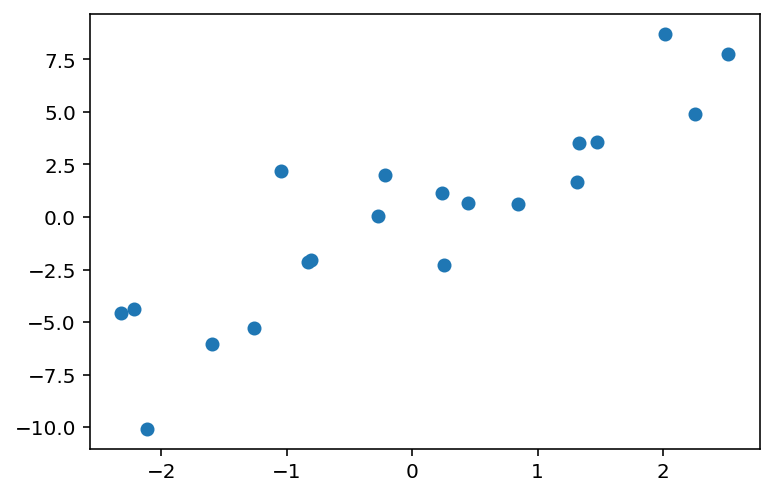

In [3]:
seed(314)
nsamples = 20
x1 = np.linspace(0, 5, nsamples) + rand(nsamples) * 0.5
x2 = 3 * x1 + 5 + randn(nsamples) * 2
X = np.c_[x1, x2]
X_bar = X.mean(axis=0, keepdims=True)
X = X - X_bar
plt.scatter(*X.T);

In [4]:
S = np.einsum("ij,ik->jk", X, X) / nsamples
eigvals, eigvects = eig(S)

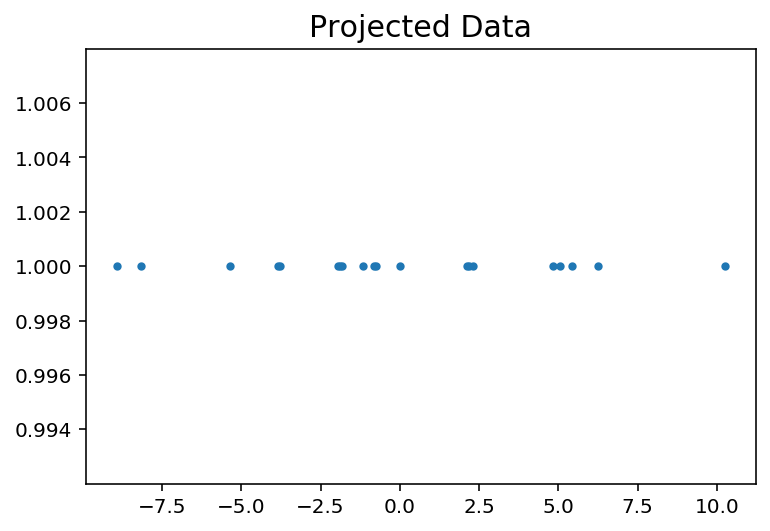

In [5]:
l = eigvals.argmax()
u1 = eigvects[:, [l]]

X_proj = X @ u1

plt.scatter(X_proj, np.ones(nsamples), s=10)
plt.title("Projected Data", fontsize=15);

### Sklearn Comparisson

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(X)
np.c_[X_proj, pca.transform(X)]

array([[ 5.03735819,  5.03735819],
       [ 4.84525815,  4.84525815],
       [10.25831817, 10.25831817],
       [ 6.24658612,  6.24658612],
       [ 5.44117203,  5.44117203],
       [-1.82480268, -1.82480268],
       [ 2.29403076,  2.29403076],
       [ 2.17571813,  2.17571813],
       [-1.87417678, -1.87417678],
       [ 0.01966285,  0.01966285],
       [-1.14778433, -1.14778433],
       [ 2.1336971 ,  2.1336971 ],
       [-0.76726156, -0.76726156],
       [-0.81728617, -0.81728617],
       [-3.76828303, -3.76828303],
       [-1.95309679, -1.95309679],
       [-3.84657501, -3.84657501],
       [-8.93551976, -8.93551976],
       [-5.35347892, -5.35347892],
       [-8.16353646, -8.16353646]])

### Proposition

The linear projection onto an $M$-dimensional subspace that maximizes the variance of the projected data is defined by the $M$ eigenvectors of the data covariance matrix $S$, corresponding to the $M$ largest eigenvalues

In [7]:
l1 = eigvals.argmax()
l2 = eigvals.argmin()

u1 = eigvects[:, [l1]]
u2 = eigvects[:, [l2]]

u1.T @ u2

array([[0.]])

### An example: The iris dataset

In [8]:
iris = load_iris()
X, y = iris["data"], iris["target"]
nsamples = len(X)

S = np.einsum("ij,ik->jk", X, X) / nsamples
eigvals, eigvects = eig(S)

# Sort in descending order
l = (-eigvals).argsort()

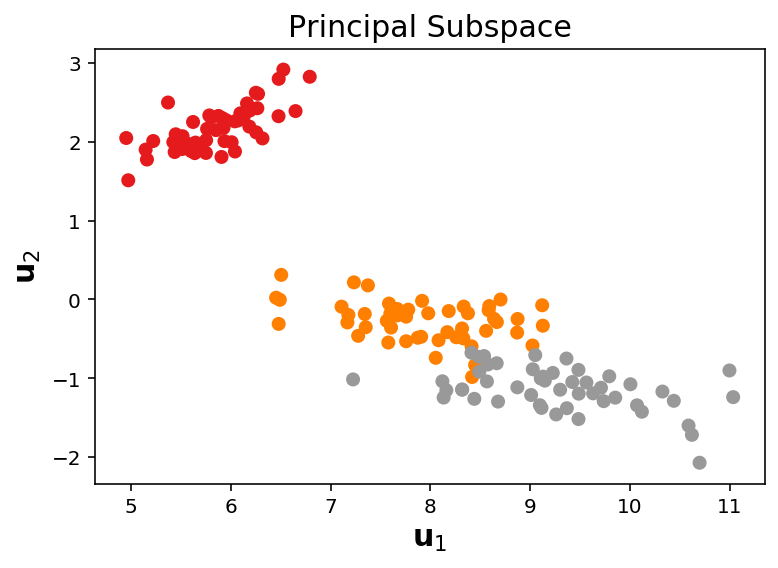

In [9]:
u = eigvects[:, l[:2]]
X_proj = X @ u

plt.scatter(*X_proj.T, c=y, cmap="Set1")
plt.title("Principal Subspace", fontsize=15)
plt.xlabel(r"${\bf u}_1$", fontsize=15)
plt.ylabel(r"${\bf u}_2$", fontsize=15);

<h2 style="color:crimson">Minimum Error Formulation</h2>

## Applications: PCA as Data Compression

In [10]:
from tensorflow.keras.datasets import mnist

In [11]:
data = mnist.load_data()
train, test = data
Xtrain, ytrain = train

In [12]:
X_sample = Xtrain[ytrain == 3]
N, M, M = X_sample.shape

Xbar = X_sample.mean(axis=0)
Xhat = (X_sample - Xbar).reshape(N, -1)

In [13]:
%%time
S = np.einsum("ij,ik->jk", Xhat, Xhat) / N
eigvals, eigvects = eig(S)

CPU times: user 1.81 s, sys: 20.8 ms, total: 1.83 s
Wall time: 1.44 s


> Because each eigenvector of the covariance matrix is a vector in the original $D$-dimensional space, we can represent the eigenvectors as images of the same size as data points.

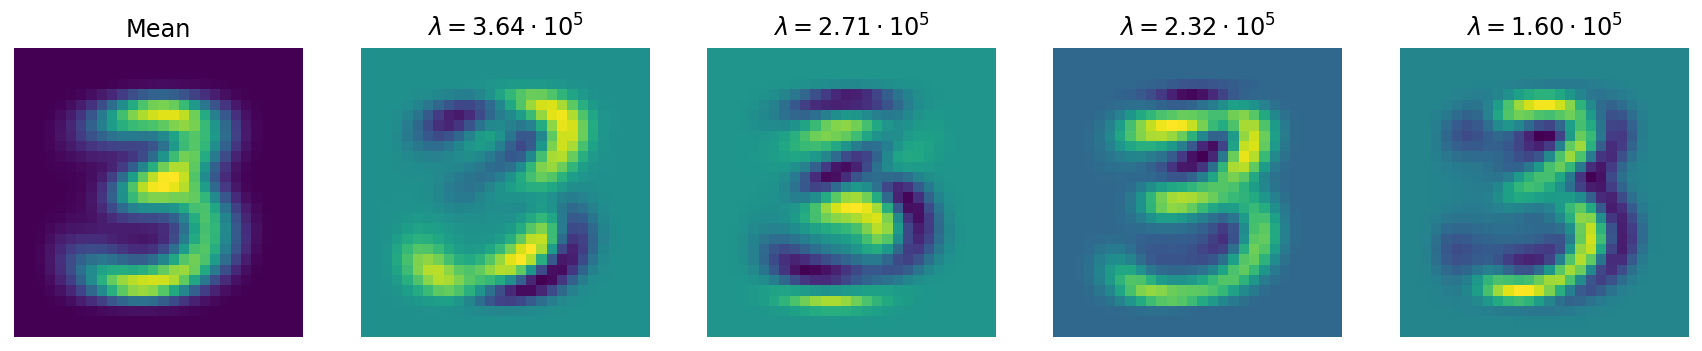

In [14]:
def format_eigval(eigval):
    label = rf"$\lambda={eigval:.2e}"
    label = label.replace("e+0", "\cdot 10^{")
    return label + "}$"

npc = 4 # number of principal components
fig, ax = plt.subplots(1, npc + 1, figsize=(15, 4))


principal_subspace = eigvects[:, :npc].reshape(M, M , npc).real
eigvectors = [format_eigval(li) for li in eigvals[:npc].real]
labels = ["Mean"] + eigvectors
pca_arrays = np.concatenate((Xbar[..., np.newaxis], principal_subspace), axis=-1)

for n, label in enumerate(labels):
    ax[n].imshow(pca_arrays[..., n])
    ax[n].axis("off")
    ax[n].set_title(label)

**The PCA approximation to a data vector ${\bf x}_n$ is given by**

$$
    \tilde{\bf x}_n = \bar{\bf x} + \sum_{m=1}^M\left({\bf x}_n^{\text T}{\bf u}_m - \bar{\bf x}^{\text T}{\bf u}_m\right) {\bf u}_m
$$

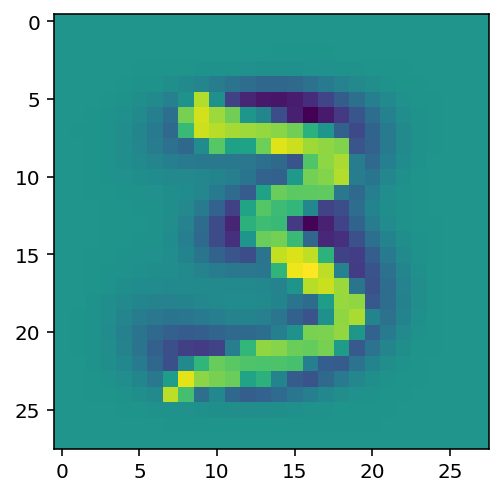

In [15]:
plt.imshow(Xhat[[13]].reshape(M, M))

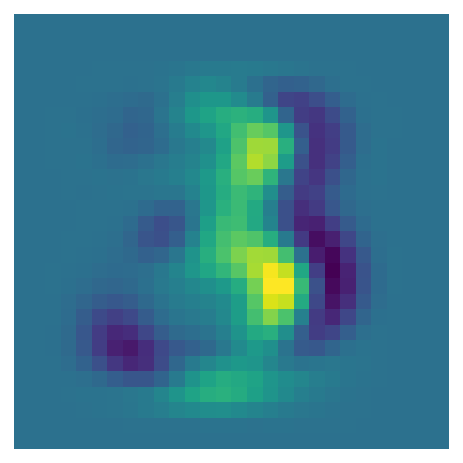

In [16]:
xn = Xhat[[13]].T

u = eigvects[:, :3].real
x_prj = ((xn.T @ u - Xbar.ravel() @ u) * u).sum(axis=1).reshape(M, M)
plt.imshow(Xbar + x_prj)
plt.axis("off");

### Animating Projection Error

In [17]:
Jhist = eigvals.real.sum() - eigvals.real.cumsum()
Jmax = Jhist.max()

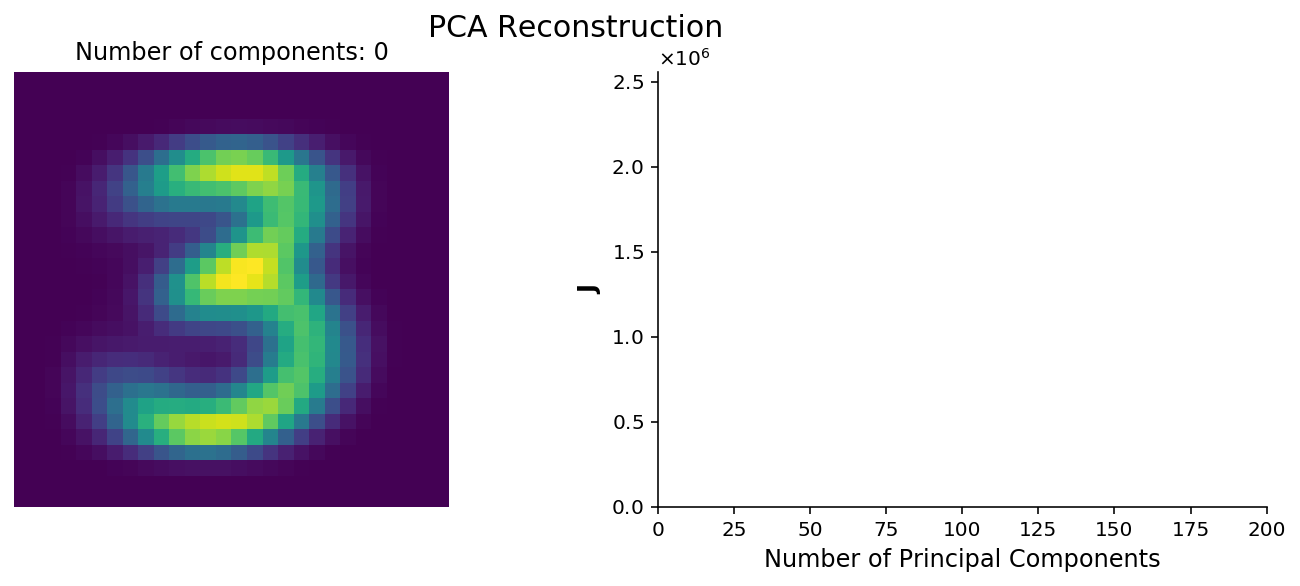

In [18]:
import matplotlib.animation as animation

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

nframes = 200
def incremental_pca(i):
    ax[0].cla()
    ax[1].cla()
    u = eigvects[:, :i].real
    x_prj = ((xn.T @ u - Xbar.ravel() @ u) * u).sum(axis=1).reshape(M, M)
    
    ax[0].imshow(Xbar + x_prj)
    ax[0].set_title(f"Number of components: {i}")
    ax[0].axis("off")
    
    ax[1].plot(Jhist[:i])
    ax[1].set_ylim(0, Jmax)
    ax[1].set_xlim(0, nframes)
    ax[1].ticklabel_format(axis="y", useMathText="True",
                        scilimits=(0,0))
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    ax[1].set_xlabel("Number of Principal Components", fontsize=12)
    ax[1].set_ylabel(r"$\bf J$", fontsize=12)
    plt.suptitle("PCA Reconstruction", fontsize=15)
    

ani = animation.FuncAnimation(fig, incremental_pca, frames=nframes,
                              interval=50)
ani.save("incremental-pca.gif", writer="imagemagick")

CPU times: user 16.6 s, sys: 177 ms, total: 16.8 s
Wall time: 15.8 s


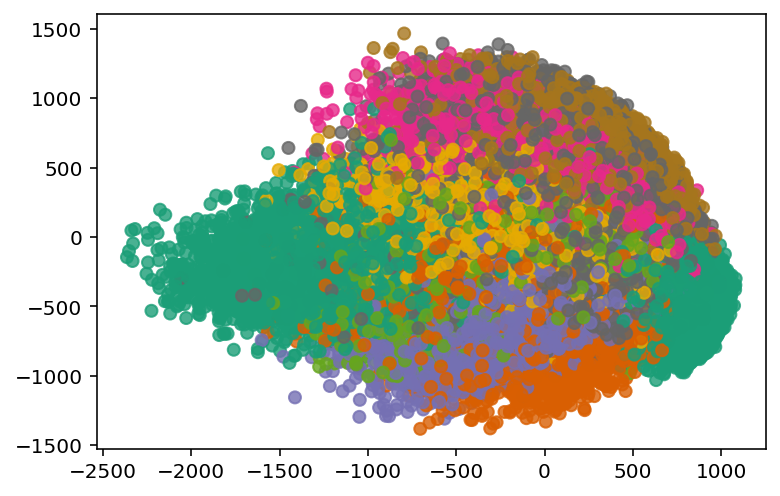

In [19]:
%%time

N, M, M = Xtrain.shape
Xbar = Xtrain.mean(axis=0)
Xhat = (Xtrain - Xbar).reshape(N, -1)


S = np.einsum("ij,ik->jk", Xhat, Xhat) / N
eigvals, eigvects = eig(S)

u = eigvects[:, :2]
proj = Xhat @ u
plt.scatter(*proj.T, c=ytrain, alpha=0.8, cmap="Dark2")

# Further References

* http://vlm1.uta.edu/~athitsos/courses/cse4309_spring2020/lectures/12_pca.pdf